<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/3.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%965_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №5. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## 2. Импортируем датасет

In [3]:
df = pd.read_csv('train.csv')
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

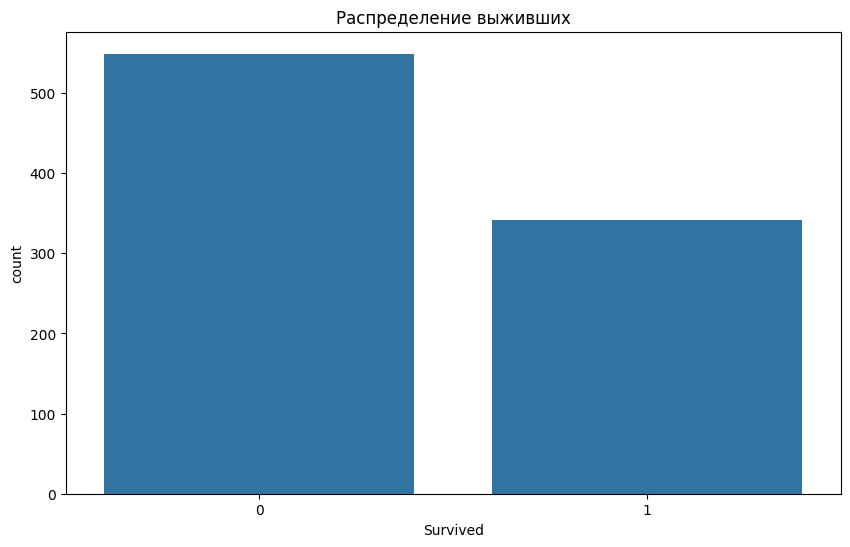

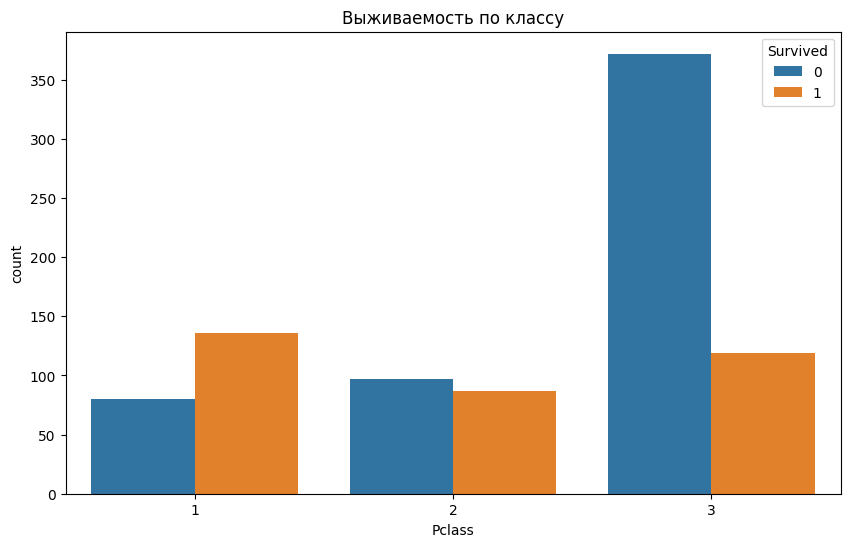

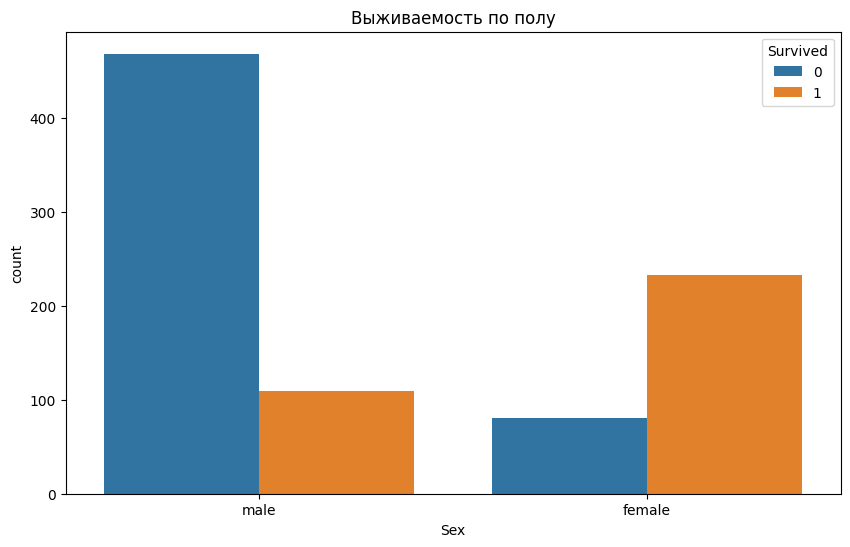

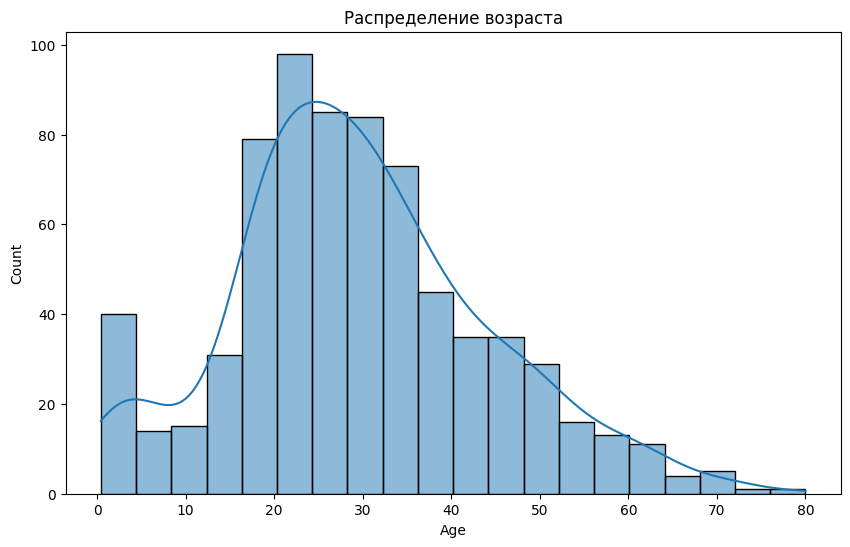

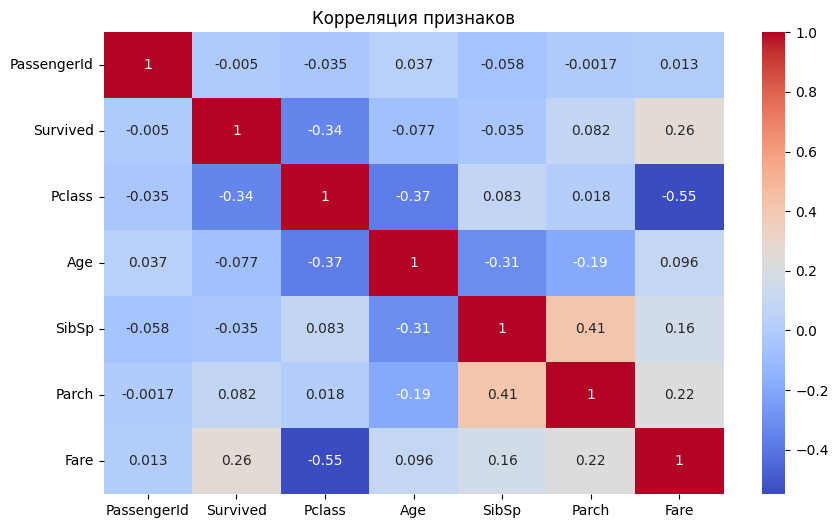

In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Визуализация
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived', data=df)
plt.title('Распределение выживших')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Выживаемость по классу')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Выживаемость по полу')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Age'].dropna(), kde=True)
plt.title('Распределение возраста')
plt.show()

# Корреляция числовых признаков
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция признаков')
plt.show()

## 4. Сформируем обучающую и тестовую выборки:


In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [11]:
from sklearn.preprocessing import LabelEncoder

train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


label_encoder = LabelEncoder()
train['Sex'] = label_encoder.fit_transform(train['Sex'])
test['Sex'] = label_encoder.transform(test['Sex'])

train['Embarked'] = label_encoder.fit_transform(train['Embarked'])
test['Embarked'] = label_encoder.transform(test['Embarked'])

## 6. Построение базовой модели:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train[features]
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')

Accuracy: 0.7877094972067039


## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [14]:
def evaluate_model(y_pred, y_test, model_name="Model"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок ({model_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print(f"Отчет классификации ({model_name}):")
    print(classification_report(y_test, y_pred))
    print(f"Точность ({model_name}): {accuracy_score(y_test, y_pred):.4f}")

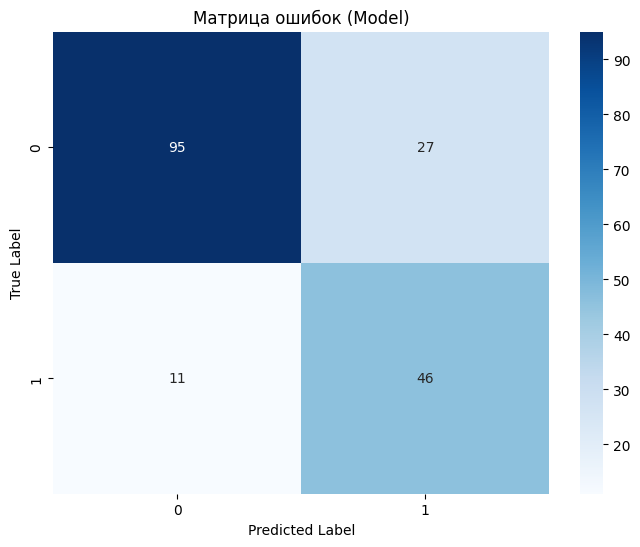

Отчет классификации (Model):
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       122
           1       0.63      0.81      0.71        57

    accuracy                           0.79       179
   macro avg       0.76      0.79      0.77       179
weighted avg       0.81      0.79      0.79       179

Точность (Model): 0.7877


In [16]:
evaluate_model(y_val, y_pred)

### 7.2. Оцените точность модели:

In [17]:
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')

Accuracy: 0.7877094972067039


## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


random_search = RandomizedSearchCV(estimator=model,param_distributions=param_distributions,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2,
                                   random_state=1,
                                   n_jobs=-1,
                                   error_score='raise')
random_search.fit(X_train, y_train)

print(f'Best parameters from RandomizedSearchCV: {random_search.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters from RandomizedSearchCV: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}


GridSearchCV

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=3,
                           verbose=2,
                           n_jobs=-1,
                            error_score='raise')
grid_search.fit(X_train, y_train)

print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters from GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


## 9. Оценка лучшей модели:

Accuracy of the best model: 0.7877094972067039


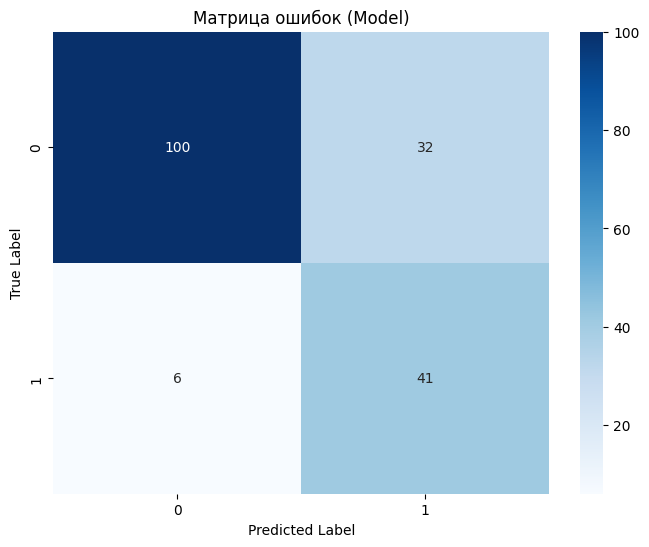

Отчет классификации (Model):
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       132
           1       0.56      0.87      0.68        47

    accuracy                           0.79       179
   macro avg       0.75      0.81      0.76       179
weighted avg       0.84      0.79      0.80       179

Точность (Model): 0.7877


In [25]:
best_model = grid_search.best_estimator_ #random_search grid_search
y_pred_best = best_model.predict(X_val)

print(f'Accuracy of the best model: {accuracy_score(y_val, y_pred_best)}')
evaluate_model(y_val, y_pred_best)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [28]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [29]:
data = pd.read_csv('train.csv')

In [ ]:
# Обработка пропущенных значений
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Преобразование категориальных признаков в числовые
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Инжиниринг признаков — префикс билета
data['TicketPrefix'] = data['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'NoPrefix')
ticket_prefix_encoder = LabelEncoder()
data['TicketPrefix'] = ticket_prefix_encoder.fit_transform(data['TicketPrefix'])

# Выбор признаков и целевой переменной
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[features]
y = data['Survived']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели "Дерево решений"
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Предсказания и оценка модели "Дерево решений"
y_pred = decision_tree_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred)
print("Точность дерева решений:", accuracy_dt)
print("Отчет классификации для дерева решений:\n", classification_report(y_test, y_pred))

# Предсказания и оценка лучшей модели (например, найденной RandomizedSearchCV)
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Точность лучшей модели:", accuracy_best)
print("Отчет классификации для лучшей модели:\n", classification_report(y_test, y_pred_best))

# Сравнение моделей
if accuracy_dt > accuracy_best:
    print("Дерево решений показало лучшую точность, чем лучшая модель.")
else:
    print("Лучшая модель показала лучшую точность, чем дерево решений.")


Точность дерева решений: 0.7821229050279329
Отчет классификации для дерева решений:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       105
           1       0.72      0.77      0.75        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.78      0.78       179

Точность лучшей модели: 0.9050279329608939
Отчет классификации для лучшей модели:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       105
           1       0.94      0.82      0.88        74

    accuracy                           0.91       179
   macro avg       0.91      0.89      0.90       179
weighted avg       0.91      0.91      0.90       179

Лучшая модель показала лучшую точность, чем дерево решений.


In [31]:
# Сохранение RandomForestClassifier
with open('model.pkl', 'wb') as file:  
    pickle.dump(model, file)

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [ ]:
import joblib
import pandas as pd

def predict_survival(model):
    try:
        pclass = int(input("Введите класс билета (1, 2 или 3): "))
        if pclass not in [1, 2, 3]:
            raise ValueError("Класс должен быть 1, 2 или 3")
        
        sex_input = input("Введите пол (мужской или женский): ").strip().lower()
        if sex_input == 'мужской':
            sex = 0
        elif sex_input == 'женский':
            sex = 1
        else:
            raise ValueError("Пол должен быть 'мужской' или 'женский'")
        
        age = float(input("Введите возраст (например, 11): "))
        if age < 0 or age > 100:
            raise ValueError("Возраст должен быть в пределах от 0 до 100")
        
        sibsp = int(input("Введите количество братьев/сестер или супругов (0–8): "))
        if sibsp < 0 or sibsp > 8:
            raise ValueError("Значение должно быть от 0 до 8")
        
        parch = int(input("Введите количество родителей/детей (0–6): "))
        if parch < 0 or parch > 6:
            raise ValueError("Значение должно быть от 0 до 6")
        
        fare = float(input("Введите стоимость билета (например, 72.5): "))
        if fare < 0 or fare > 600:
            raise ValueError("Стоимость должна быть от 0 до 600")
        
        embarked_input = input("Введите порт посадки (C, Q или S): ").strip().upper()
        if embarked_input not in ['C', 'Q', 'S']:
            raise ValueError("Порт должен быть C, Q или S")
        
        embarked_map = {'C': 0, 'Q': 1, 'S': 2}
        embarked = embarked_map[embarked_input]

        # Вывод введённых данных
        print("\nВведённые параметры:")
        print(f"  Класс: {pclass}")
        print(f"  Пол: {'мужской' if sex == 0 else 'женский'}")
        print(f"  Возраст: {age}")
        print(f"  Братья/сёстры или супруги на борту: {sibsp}")
        print(f"  Родители/дети на борту: {parch}")
        print(f"  Стоимость билета: {fare}")
        print(f"  Порт посадки: {embarked_input} (кодировка: {embarked})")

        # Подготовка данных
        features = pd.DataFrame([{
            'Pclass': pclass,
            'Sex': sex,
            'Age': age,
            'SibSp': sibsp,
            'Parch': parch,
            'Fare': fare,
            'Embarked': embarked
        }])

        prediction = model.predict(features)
        result = "Выживет" if prediction[0] == 1 else "Не выживет"
        print(f"\nРезультат предсказания: {result}")

    except ValueError as e:
        print(f"Ошибка: {e}")
    except Exception as e:
        print(f"Произошла ошибка: {e}")

# Загрузка модели
model = joblib.load('model.pkl')

# Запуск предсказания
predict_survival(model)



Введённые параметры:
  Класс: 3
  Пол: женский
  Возраст: 11.0
  Братья/сёстры или супруги на борту: 0
  Родители/дети на борту: 0
  Стоимость билета: 221.0
  Порт посадки: Q (кодировка: 1)

Результат предсказания: Не выживет


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [47]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [48]:
diabetes = load_diabetes()

In [49]:
X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [50]:
# Пайплайн
rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=3))
])

In [51]:
# Обучение
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=3))])

In [52]:
# Оценка
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MSE на обучающей выборке: {mse_train:.2f}')
print(f'MSE на тестовой выборке: {mse_test:.2f}')
print(f'R² на обучающей выборке: {r2_train:.2f}')
print(f'R² на тестовой выборке: {r2_test:.2f}')

MSE на обучающей выборке: 451.98
MSE на тестовой выборке: 3198.26
R² на обучающей выборке: 0.93
R² на тестовой выборке: 0.41


In [53]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [5, 10, 15],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}


In [54]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"MSE на обучающей выборке: {mse_train:.2f}")
print(f"MSE на тестовой выборке: {mse_test:.2f}")
print(f"R² на обучающей выборке: {r2_train:.2f}")
print(f"R² на тестовой выборке: {r2_test:.2f}")

MSE на обучающей выборке: 708.98
MSE на тестовой выборке: 3237.80
R² на обучающей выборке: 0.88
R² на тестовой выборке: 0.40
